c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                0                                                  1      2  \
0     screen_name                                                NaN    NaN   
1      imranyebot                             YEA now that note GOOD    bot   
2          zawvrk  Listen to This Charming Man by The Smiths  htt...  human   
3        zawarbot  wish i can i would be seeing other hoes on the...    bot   
4  ahadsheriffbot  The decade in the significantly easier schedul...    bot   

            3  
0  class_type  
1      others  
2       human  
3      others  
4      others  
   label  generated
0    NaN        NaN
1    bot        1.0
2  human        0.0
3    bot        1.0
4    bot        1.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\test\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


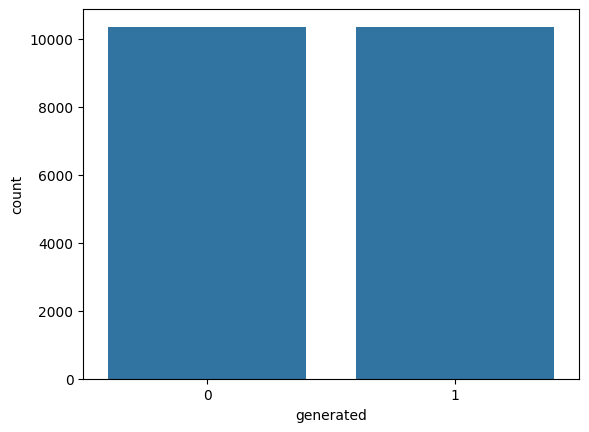

                                              preprocess  generated
1                                          yea note good          1
2                          listen charming man smiths uo          0
3                      wish would seeing hoes worst part          1
4            decade significantly easier schedule like h          1
5                                                                 1
...                                                  ...        ...
20708            met abversion science commitment people          1
20709                   land opportunity programme lives          1
20710                                 love country would          1
20711                                      bestie dk wzm          0
20712  generate existing sparching like enter configu...          1

[20712 rows x 2 columns]


In [ ]:
import nltk
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

tweets = pd.read_csv("train.csv", encoding='latin', header=None, delimiter=",", quotechar='"')
print(tweets.head())
tweets['tweets']= tweets[1]
tweets['label']=tweets[2]

label_mapping = {'bot': 1, 'human': 0}
tweets['generated'] = tweets['label'].map(label_mapping)
print(tweets[['label','generated']].head())
tweets = tweets.replace([np.inf, -np.inf], np.nan).dropna(subset=['generated'])
tweets['generated'] = tweets['generated'].astype(int)

columns_to_select =['tweets','generated']
tweets_new = tweets.loc[:,columns_to_select].copy()
tweets_new.dropna(inplace=True)

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def preprocess(tweets_new):
    tweets_new = re.sub(r'([a-z])([A-Z])',r'\1 \2',tweets_new)
    words = tweets_new.split()
    words = [word.lower() for word in words  if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    tweets_new=' '.join(words)
    tweets_new = re.sub(r'[^\w\s]','',tweets_new)
    tweets_new = tweets_new.replace('$','')

    return tweets_new

tweets_new['preprocess'] = tweets_new['tweets'].apply(preprocess)

sns.countplot(data= tweets_new, x='generated')
plt.show()



print(tweets_new[['preprocess','generated']])

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.cuda
from torch.utils.data import DataLoader,TensorDataset,random_split
from sklearn.metrics import accuracy_score,classification_report,precision_score,recall_score,f1_score


sample_size = 10000
sampled_tweets = tweets_new.sample(n=sample_size, random_state=42)
print(len(tweets_new['preprocess']), len(tweets_new['generated']))
X_train_val, X_test, y_train_val, y_test = train_test_split(sampled_tweets['preprocess'], sampled_tweets['generated'],test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, train_size=0.8,random_state=42)
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case =True, padding = True,truncation = True, max_length = 128)


encoded_train = tokenizer(X_train.tolist(),padding=True, truncation=True,return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(),padding=True,truncation=True,return_tensors='pt' )

train_label = torch.tensor(y_train.values)
val_label = torch.tensor(y_val.values)

train_datast = TensorDataset(encoded_train['input_ids'],encoded_train['attention_mask'],train_label)
val_datast = TensorDataset(encoded_val['input_ids'],encoded_val['attention_mask'],val_label)

train_loader = DataLoader(train_datast,batch_size=8,shuffle=True)
val_loader = DataLoader(val_datast,batch_size=8,shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device =torch.device("cuda"if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5,correct_bias=False,weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer ,"min",patience=2)
epochs = 10







20712 20712
6400 6400
1600 1600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#Training loop Starting
from torch import int64
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0.0
best_model_state_dict = None


for epoch  in range(epochs):
    model.train()
    total_loss = 0
    total_train_loss = 0
    correct_train_preds = 0
    total_train_samples = 0

    for batch in train_loader:
        input_ids, attention_mask,labels = batch
        input_ids, attention_mask,labels =input_ids.to(device), attention_mask.to(device),labels.to(device,dtype=torch.int64)

        optimizer.zero_grad()
        outputs = model(input_ids,attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0) #Gradient clipping to avoid exploding gradients
        optimizer.step()

        predictions = logits.argmax(dim=-1)
        correct_train_preds += (predictions == labels).sum().item()
        total_train_samples += labels.size(0)


avg_train_loss= total_loss / len(train_loader)
train_accuracy = correct_train_preds / total_train_samples
train_loss_history.append(avg_train_loss)
train_accuracy_history.append(train_accuracy)
print(f"Epoch {epoch + 1}/{epochs},Average Training Loss: {avg_train_loss:.2f},Training Accuracy:{train_accuracy:.2f}")

Epoch 10/10,Average Training Loss: 0.06,Training Accuracy:0.99


In [ ]:
#Validation Loop
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device,dtype=torch.int64)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_preds.extend(torch.argmax(logits,dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds)
val_recall = recall_score(val_labels,val_preds )
val_f1 = f1_score(val_labels,val_preds)
print(f"Validation Accuracy:{val_accuracy:.2f}")
print(f"Validation Precision:{val_precision:.2f}")
print(f"Validation Recall:{val_recall:.2f}")
print(f"Validation F1-score:{val_f1:.2f}")

Validation Accuracy:0.70
Validation Precision:0.72
Validation Recall:0.60
Validation F1-score:0.66


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [ ]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_test_preprocessed = X_test.astype(str)
batch_size = 4


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=128)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased').to(device)
model.eval()


predictions = []

with torch.no_grad():
    for i in range(0, len(X_test_preprocessed), batch_size):
        batch_data = X_test_preprocessed.iloc[i:i+batch_size].tolist()


        tokenized_batch = tokenizer(batch_data, padding=True, truncation=True, return_tensors='pt')


        tokenized_batch = {key: value.to(device) for key, value in tokenized_batch.items()}

        try:

            outputs = model(**tokenized_batch)
            logits = outputs.logits


            batch_predictions = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            predictions.extend(batch_predictions)

        except RuntimeError as e:
            print(f"Error at batch {i}: {e}")
            torch.cuda.empty_cache()


submission = pd.DataFrame({'generated': predictions})
submission.to_csv('submission.csv', index=False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
